# Exploratory Data Analysis on PWM Behavioral Data

**Goal** This notebook will explore the new dataset to see what trends are present now that violations are properly tracked and timeouts are not incorrectly marked as violations.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import pandas as pd

from multiglm.data.dataset_loader import *
from multiglm.data import ANIMAL_IDS

sns.set_context("talk")

%load_ext autoreload
%autoreload 2

choice_palette = sns.color_palette("Set2", 3)

## Load In

In [3]:
full_df = DatasetLoader(
    animal_ids=ANIMAL_IDS,
    data_type="new_all",
).load_data()
trained_df = DatasetLoader(
    animal_ids=ANIMAL_IDS,
    data_type="new_trained",
).load_data()

Loading data for animal ids:  ['W051', 'W060', 'W065', 'W066', 'W068', 'W072', 'W073', 'W074', 'W075', 'W078', 'W080', 'W081', 'W082', 'W083', 'W088', 'W089', 'W094']
Loading data for animal ids:  ['W051', 'W060', 'W065', 'W066', 'W068', 'W072', 'W073', 'W074', 'W075', 'W078', 'W080', 'W081', 'W082', 'W083', 'W088', 'W089', 'W094']


## Sessions

In [4]:
trial_counts = (
    full_df.groupby(["training_stage", "animal_id"]).size().reset_index(name="count")
)

merged_counts = pd.merge(
    full_df.groupby(["animal_id", "training_stage"])["session"].nunique().reset_index(),
    trial_counts,
    on=["animal_id", "training_stage"],
)

merged_counts = pd.merge(
    full_df.groupby(["training_stage", "animal_id", "session"])
    .trial.max()
    .reset_index()
    .groupby(["training_stage", "animal_id"])
    .trial.mean()
    .reset_index(),
    merged_counts,
    on=["animal_id", "training_stage"],
)

merged_counts.head()

,training_stage,animal_id,trial,session,count
0,1,W051,244.157895,19,4639
1,1,W060,228.062500,32,7298
2,1,W065,228.105263,19,4334
3,1,W066,221.294118,17,3762
4,1,W068,207.842105,19,3949


Text(0.5, 1.0, 'N trials per Session')

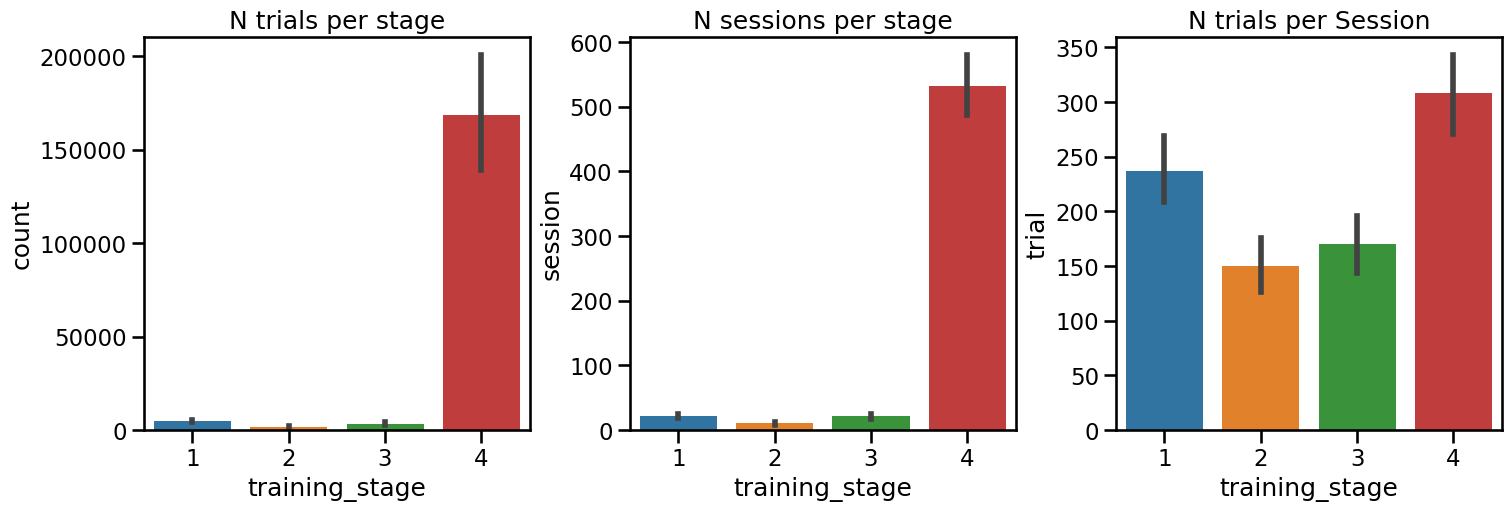

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)


sns.barplot(merged_counts, x="training_stage", y="count", ax=ax[0])
ax[0].set_title("N trials per stage")


sns.barplot(data=merged_counts, x="training_stage", y="session", ax=ax[1])
ax[1].set_title("N sessions per stage")

sns.barplot(data=merged_counts, x="training_stage", y="trial", ax=ax[2])
ax[2].set_title("N trials per Session")

### Trained DF Stats

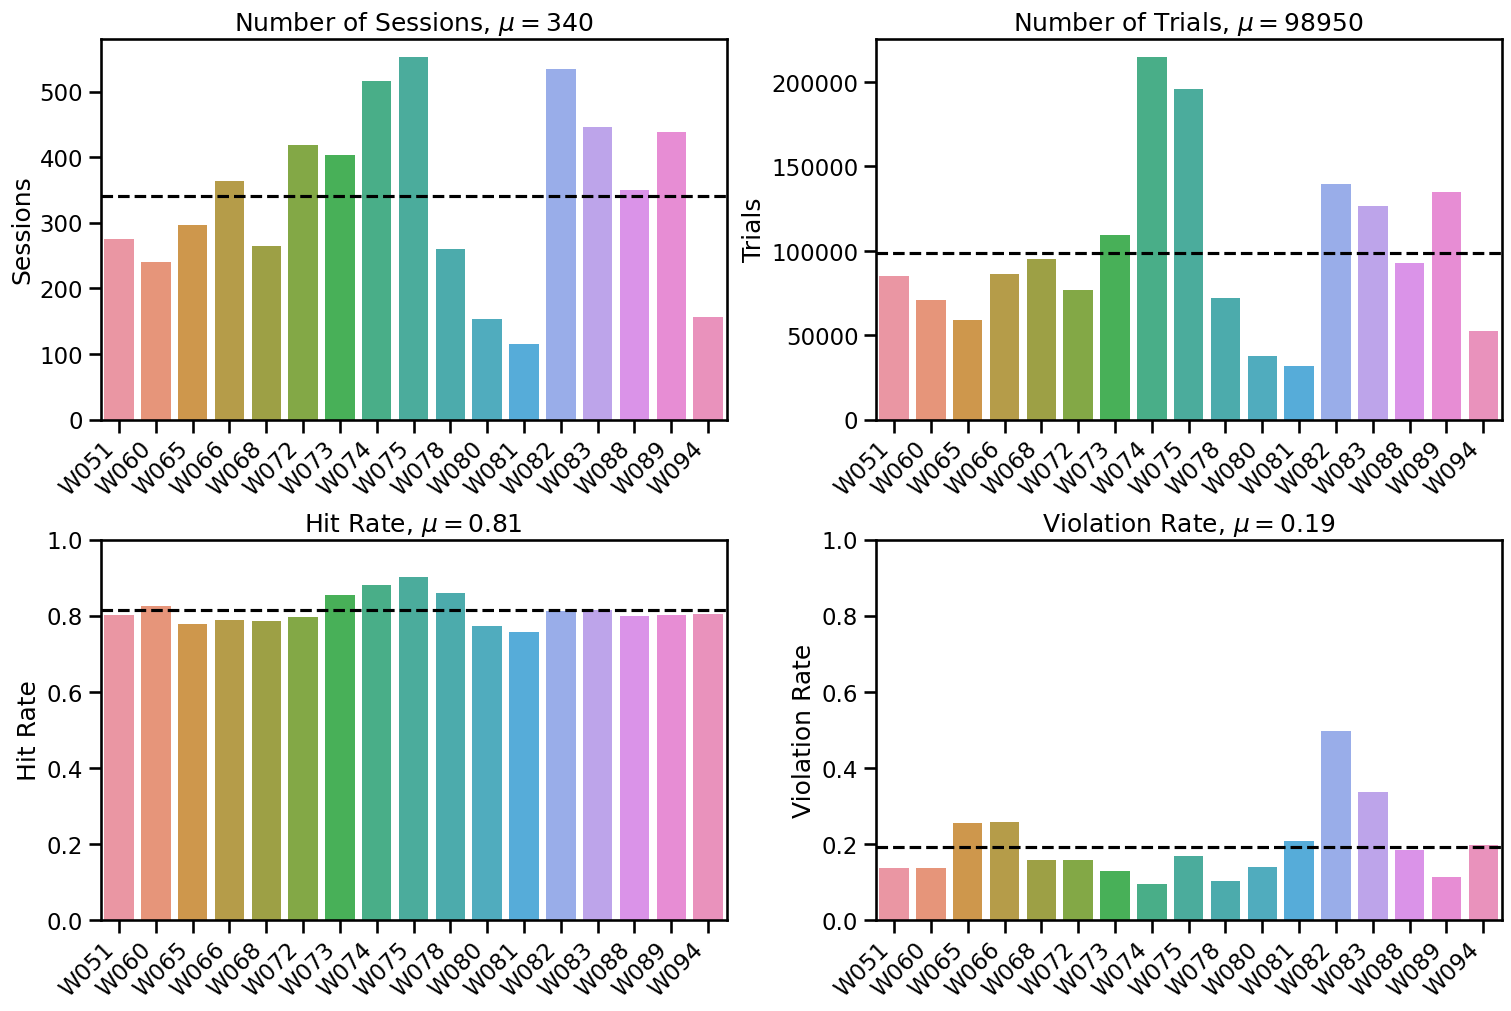

In [10]:
trained_df_count_stats = pd.read_csv(
    "../data/processed/dataset_thresholding/trained_threshold_df_stats.csv"
)

fig, ax = plt.subplots(2, 2, figsize=(15, 10), constrained_layout=True)


plot_df = trained_df_count_stats

sns.barplot(x="animal_id", y="n_sessions", data=plot_df, ax=ax[0, 0])
session_mean = plot_df.n_sessions.mean()
ax[0, 0].axhline(session_mean, color="k", linestyle="--")
_ = ax[0, 0].set(
    title=f"Number of Sessions, $\mu = ${session_mean:.0f}",
    xlabel="",
    ylabel="Sessions",
)

sns.barplot(x="animal_id", y="n_trials", data=plot_df, ax=ax[0, 1])
trials_mean = plot_df.n_trials.mean()
ax[0, 1].axhline(trials_mean, color="k", linestyle="--")
_ = ax[0, 1].set(
    title=f"Number of Trials, $\mu= ${trials_mean:.0f}", xlabel="", ylabel="Trials"
)


sns.barplot(x="animal_id", y="avg_hit", data=plot_df, ax=ax[1, 0])
hit_mean = plot_df.avg_hit.mean()
ax[1, 0].axhline(hit_mean, color="k", linestyle="--")
_ = ax[1, 0].set(
    title=f"Hit Rate, $\mu = ${hit_mean:.2f}", xlabel="", ylabel="Hit Rate", ylim=(0, 1)
)

sns.barplot(x="animal_id", y="avg_violation", data=plot_df, ax=ax[1, 1])
violation_mean = plot_df.avg_violation.mean()
ax[1, 1].axhline(violation_mean, color="k", linestyle="--")
_ = ax[1, 1].set(
    title=f"Violation Rate, $\mu = ${violation_mean:.2f}",
    xlabel="",
    ylabel="Violation Rate",
    ylim=(0, 1),
)

for a in ax.flatten():
    _ = a.set_xticklabels(a.get_xticklabels(), rotation=45, ha="right")

## Hit Rates

* over stages by animal (save data out)

In [16]:
session_hit_by_stage = (
    full_df.groupby(["animal_id", "training_stage", "session"])
    .hit.mean()
    .reset_index()
    .groupby(["animal_id", "training_stage"])
    .hit.mean()
    .reset_index()
)
session_hit_by_stage.head()

,animal_id,training_stage,hit
0,W051,1,0.973147
1,W051,2,0.995332
2,W051,3,0.517187
3,W051,4,0.739582
4,W060,1,0.938054


[Text(0.5, 1.0, 'Hit Rate by Stage'),
 Text(0.5, 0, 'Training Stage'),
 Text(0, 0.5, 'Hit Rate'),
 (0.0, 1.0)]

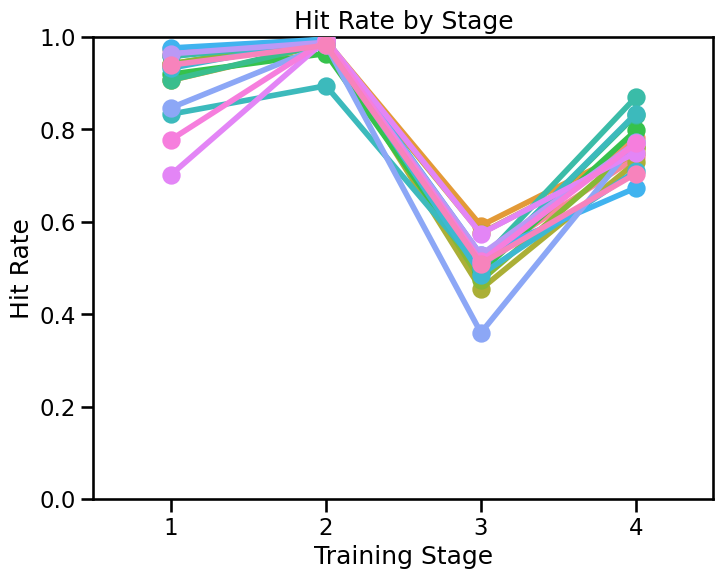

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.pointplot(
    x="training_stage", y="hit", hue="animal_id", data=session_hit_by_stage, ax=ax
)
ax.legend_.remove()

ax.set(
    title="Hit Rate by Stage",
    xlabel="Training Stage",
    ylabel="Session Avg. Hit Rate",
    ylim=(0, 1),
)

## Violation Rates

- over stages by animal (save data out)

In [22]:
session_violation_by_stage = (
    full_df.groupby(["animal_id", "training_stage", "session"])
    .violation.mean()
    .reset_index()
    .groupby(["animal_id", "training_stage"])
    .violation.mean()
    .reset_index()
)
session_violation_by_stage.head()

,animal_id,training_stage,violation
0,W051,1,0.193562
1,W051,2,0.173270
2,W051,3,0.273946
3,W051,4,0.154241
4,W060,1,0.257598


[Text(0.5, 1.0, 'Violation Rate by Stage'),
 Text(0.5, 0, 'Training Stage'),
 Text(0, 0.5, 'Session Avg. Violation Rate'),
 (0.0, 1.0)]

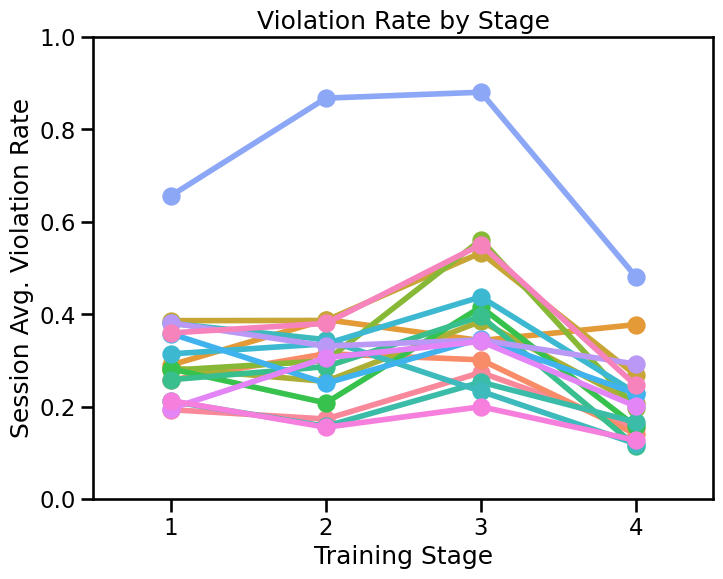

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.pointplot(
    x="training_stage",
    y="violation",
    hue="animal_id",
    data=session_violation_by_stage,
    ax=ax,
)
ax.legend_.remove()

ax.set(
    title="Violation Rate by Stage",
    xlabel="Training Stage",
    ylabel="Session Avg. Violation Rate",
    ylim=(0, 1),
)

## Hit & Violation

### By Stage

In [38]:
hit_viols_by_stage = pd.merge(
    session_hit_by_stage, session_violation_by_stage, on=["animal_id", "training_stage"]
)

hit_viols_by_stage.to_csv(
    "../data/processed/from_eda/01_session_avg_hit_viols_by_stage.csv", index=False
)

hit_viols_by_stage.head()

,animal_id,training_stage,hit,violation
0,W051,1,0.973147,0.193562
1,W051,2,0.995332,0.173270
2,W051,3,0.517187,0.273946
3,W051,4,0.739582,0.154241
4,W060,1,0.938054,0.257598


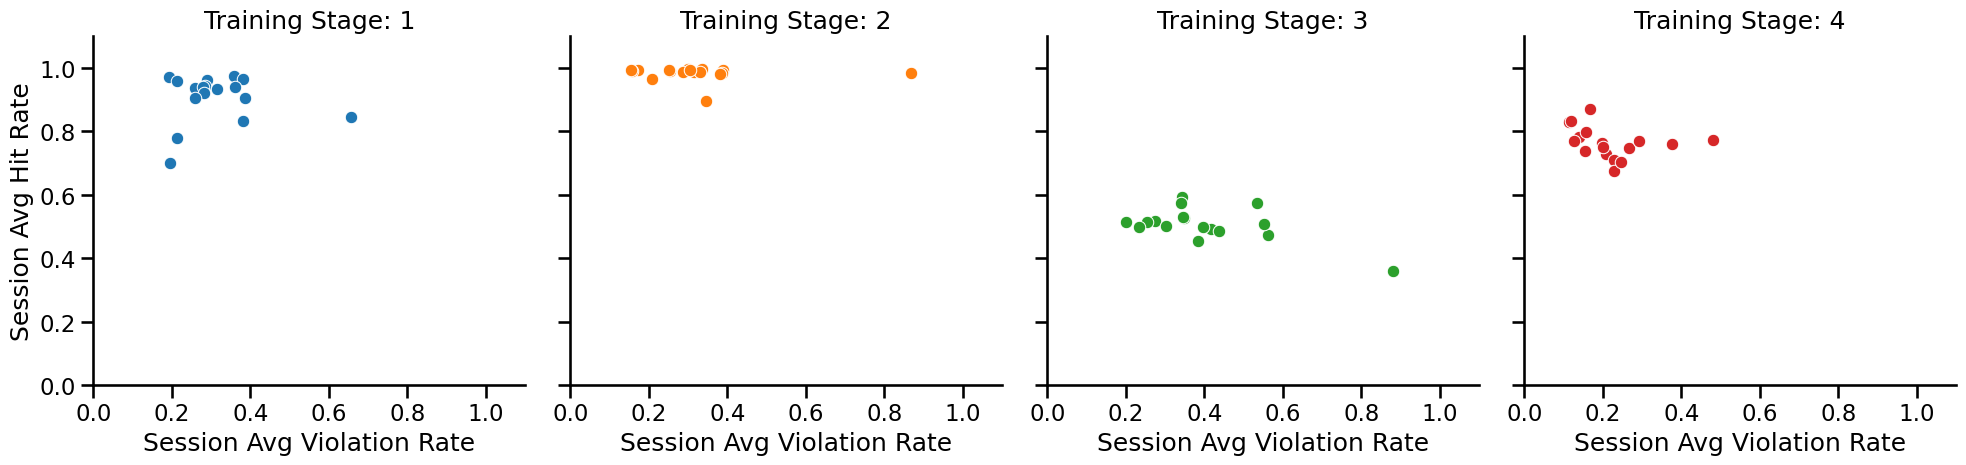

In [32]:
g = sns.FacetGrid(
    data=hit_viols_by_stage,
    col="training_stage",
    hue="training_stage",
    sharey=True,
    sharex=True,
    height=5,
    aspect=1,
    xlim=(0, 1.1),
    ylim=(0, 1.1),
)
g.map(sns.scatterplot, "violation", "hit")

g.set_axis_labels(x_var="Session Avg Violation Rate", y_var="Session Avg Hit Rate")
g.set_titles("Training Stage: {col_name}")

### Trained Data

In [42]:
trained_hit_viol_rates = (
    trained_df.groupby(["animal_id", "session"])
    .agg({"hit": "mean", "violation": "mean"})
    .reset_index()
    .groupby(["animal_id"])
    .agg({"hit": "mean", "violation": "mean"})
    .rename(columns={"hit": "", "violation": "trained_violation"})
    .reset_index()
)


trained_hit_viol_rates.to_csv(
    "../data/processed/from_eda/01_trained_session_avg_hit_viol_rates.csv", index=False
)

trained_hit_viol_rates.head()

,animal_id,trained_hit,trained_violation
0,W051,0.796836,0.154370
1,W060,0.825368,0.149891
2,W065,0.775634,0.260626
3,W066,0.788768,0.253332
4,W068,0.778252,0.163857


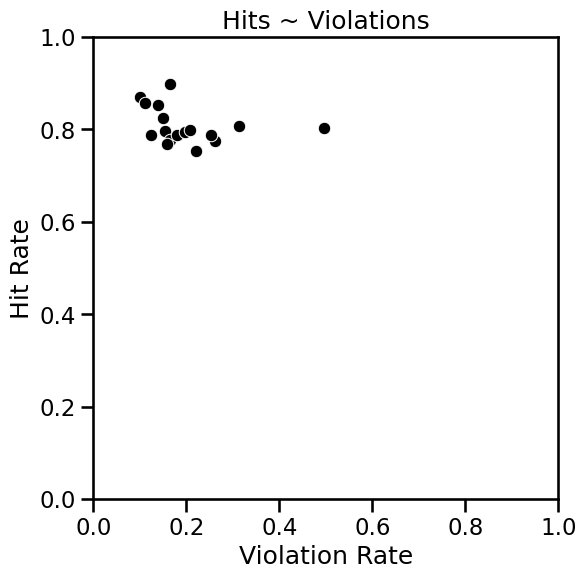

In [46]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(
    data=trained_hit_viol_rates,
    y="trained_hit",
    x="trained_violation",
    color="k",
    ax=ax,
)

_ = ax.set(
    ylabel="Hit Rate",
    xlabel="Violation Rate",
    title="Hits ~ Violations",
    ylim=(0, 1),
    xlim=(0, 1),
)

### Stage Perf Predicting Final Hit Rate

In [49]:
hit_viol_training_and_trained = pd.merge(
    hit_viols_by_stage, trained_hit_viol_rates, how="left", on="animal_id"
)

hit_viol_training_and_trained.head()

,animal_id,training_stage,hit,violation,trained_hit,trained_violation
0,W051,1,0.973147,0.193562,0.796836,0.154370
1,W051,2,0.995332,0.173270,0.796836,0.154370
2,W051,3,0.517187,0.273946,0.796836,0.154370
3,W051,4,0.739582,0.154241,0.796836,0.154370
4,W060,1,0.938054,0.257598,0.825368,0.149891


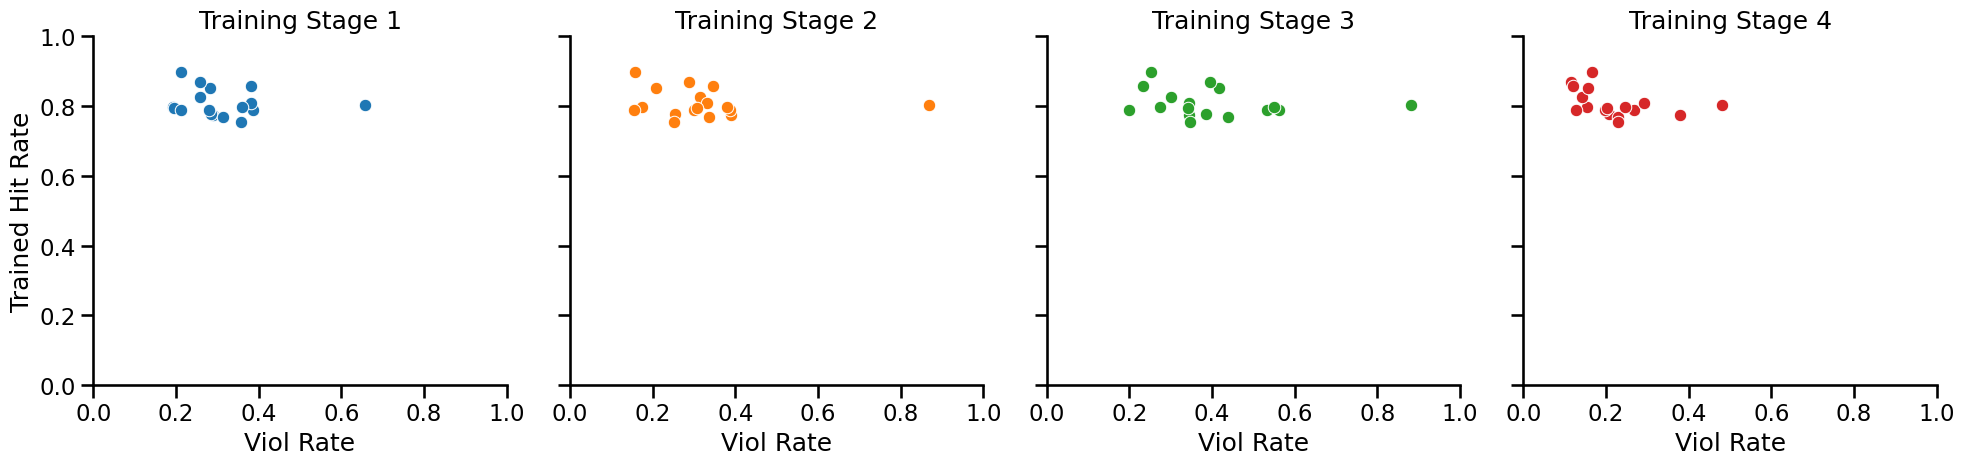

In [51]:
g = sns.FacetGrid(
    data=hit_viol_training_and_trained,
    col="training_stage",
    hue="training_stage",
    sharey=True,
    sharex=True,
    height=5,
    aspect=1,
    xlim=(0, 1),
    ylim=(0, 1),
)
g.map(sns.scatterplot, "violation", "trained_hit")

g.set_axis_labels(x_var="Viol Rate", y_var="Trained Hit Rate")
g.set_titles("Training Stage {col_name}")

### Post Violation Hit Rate

In [55]:
# Step 1: Add Prev Violation Column
def calculate_prev_violation(group):
    session_boundaries_mask = group["session"].diff() == 0
    group["prev_violation"] = (
        group["violation"].shift() * session_boundaries_mask
    ).fillna(0)
    return group


trained_df = (
    trained_df.groupby("animal_id")
    .apply(calculate_prev_violation)
    .reset_index(drop=True)
)




,animal_id,prev_violation,hit
0,W051,0.0,0.807501
1,W051,1.0,0.770882
2,W060,0.0,0.832742
3,W060,1.0,0.779308
4,W065,0.0,0.780090


In [69]:
# Step 2: Calculate Hit Rate Post Violation or not
viol_hit_rates = (
    trained_df.groupby(["animal_id", "session", "prev_violation"])
    .hit.mean()
    .reset_index()
    .groupby(["animal_id", "prev_violation"])
    .hit.mean()
    .reset_index()
    .rename({"hit": "hit_rate"}, axis=1)
)

viol_hit_rates.head()

,animal_id,prev_violation,hit_rate
0,W051,0.0,0.803490
1,W051,1.0,0.764054
2,W060,0.0,0.830631
3,W060,1.0,0.783092
4,W065,0.0,0.776971


In [70]:
# Step 3: Turn long form -> Wide Form to plot each column
wide_hit_rates = viol_hit_rates.pivot(
    index="animal_id", columns="prev_violation", values="hit_rate"
)

wide_hit_rates.columns = ["hit_rate_no_prev_viol", "hit_rate_with_prev_viol"]

wide_hit_rates.reset_index(inplace=True)

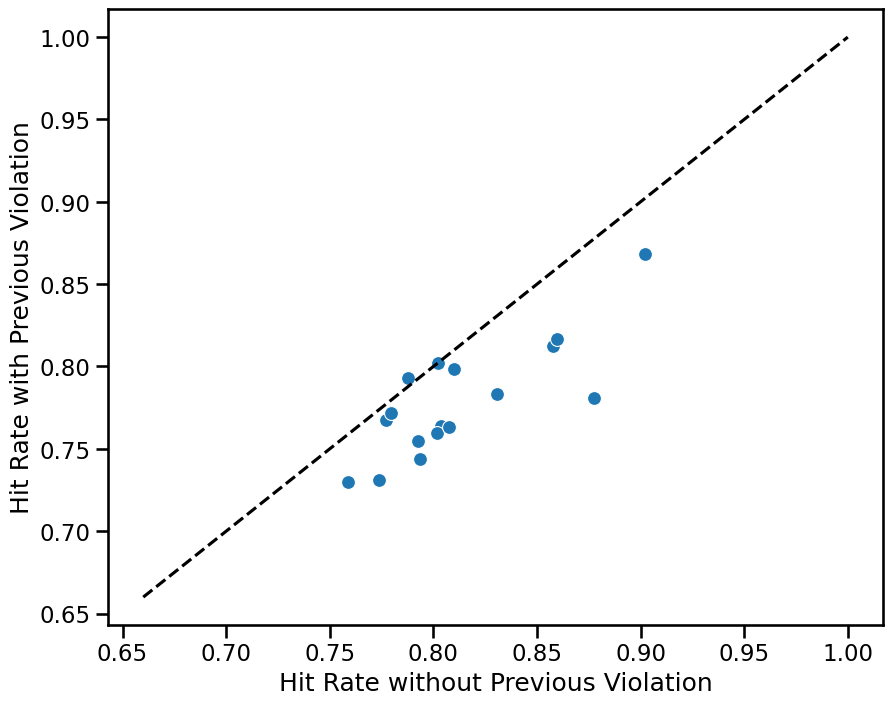

In [71]:
limits = (0.66, 1)
# Scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=wide_hit_rates, x="hit_rate_no_prev_viol", y="hit_rate_with_prev_viol", s=100
)

plt.plot(limits, limits, "k--", label="Unity Line")

plt.xlabel("Hit Rate without Previous Violation")
plt.ylabel("Hit Rate with Previous Violation")

plt.show()

In [ ]:
#TODO Save out!!

## Number of Delays


In [ ]:
# get unique delay values for each animal
unique_delays = (
    RAT_DF.groupby(["subject_id", "training_stage_cat"]).delay.unique().reset_index()
)

# get the number of unique delay values for each animal
unique_delays["n_unique_delays"] = unique_delays.delay.apply(lambda x: len(x))

In [ ]:
g = sns.FacetGrid(
    data=RAT_DF,
    row="subject_id",
    col="training_stage_cat",
    hue="training_stage_cat",
    sharey="col",
    sharex="col",
    height=4,
    aspect=1.3,
)
g.map(sns.histplot, "delay")
g.set_titles("{row_name} stage {col_name}")

In [ ]:
g = sns.catplot(
    x="training_stage_cat",
    y="n_unique_delays",
    col="subject_id",
    col_wrap=4,
    hue="subject_id",
    data=unique_delays.query("training_stage_cat != 1"),
    kind="bar",
    dodge=False,
    sharey=False,
)

## Performance ~ Delay

### Hits

In [ ]:
fig,ax = plt.subplots(figsize=(12, 4))
sns.barplot(data=RAT_DF.query("training_stage >=  3"), x="delay", y="hit", color='green',ax=ax)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set(title="Stage 3+ Hit Rates ~ Delay", ylim=(0, 1))

In [ ]:
g = sns.catplot(
    x="delay",
    y="hit",
    col="subject_id",
    col_wrap=4,
    hue="subject_id",
    data=RAT_DF.query("training_stage >=  3"),
    kind="bar",
    dodge=False,
    sharey=True,
    sharex=False,
)

g.set(ylim=(0.5, 1))

### Violations

In [ ]:
discrete_delay_df = RAT_DF.query("training_stage >=  3").groupby(["delay"]).hit.mean().reset_index()
discrete_delay_df['viol'] =  RAT_DF.query("training_stage >=  3").groupby(["delay"]).violation.mean().values
discrete_delay_df.plot(kind="bar", x="delay", y=["hit", "viol"], color=["green", "orange"], figsize=(12, 4))

Next notebook: EDA_02_predict_perf


This requires making a large data frame with 

animal id, n delays, viol stage 1-4, hit stage 1-4
Predict time to train

Predict final hit rate